In [15]:
import os
from typing import Annotated, List, TypedDict, Literal
from langchain_huggingface import HuggingFaceEndpoint
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.checkpoint.memory import InMemorySaver # Required for Human-in-the-loop
from langgraph.types import Command, interrupt
from dotenv import load_dotenv

load_dotenv()

# Initialize LLM
llm = HuggingFaceEndpoint(
    repo_id="meta-llama/Meta-Llama-3.1-8B-Instruct",
    task="conversational",
    max_new_tokens=512,
    temperature=0.1,
)

class AgentState(TypedDict):
    messages: Annotated[List[BaseMessage], add_messages]
    next_agent: str

In [16]:
# 1. MOCK DATABASE (No APIs needed)
MOCK_INVENTORY = {
    "SKU-001": {"name": "Semiconductors", "stock": 500, "lead_time": 14, "supplier": "Taiwan-Tech"},
    "SKU-002": {"name": "Lithium Cells", "stock": 1200, "lead_time": 30, "supplier": "Global-Battery"},
    "SKU-003": {"name": "Display Panels", "stock": 50, "lead_time": 21, "supplier": "Seoul-Display"}
}

In [17]:
def risk_scout_node(state: AgentState):
    return {"messages": [AIMessage(content="Risk Report: Port strike in Taiwan detected.")]}

def impact_analyst_node(state: AgentState):
    return {"messages": [AIMessage(content="Database Impact: SKU-001 stock at risk.")]}

def logistics_planner_node(state: AgentState):
    # This node contains your 'interrupt' logic
    human_feedback = interrupt("Approve plan? (yes/no):")
    return {"messages": [AIMessage(content=f"Planner Finalized: User said {human_feedback}")]}
    
def supervisor_node(state: AgentState):
    # Get the last message content
    messages = state["messages"]
    last_msg = messages[-1].content if messages else ""
    
    print(f"--- [SUPERVISOR] Logic Check. Last Message: {last_msg[:50]}... ---")

    # 1. Start with Risk Scout
    if len(messages) <= 1: 
        return {"next_agent": "RiskScout"}
    
    # 2. If Risk Scout just finished, go to Impact Analyst
    if "Risk Report" in last_msg:
        return {"next_agent": "ImpactAnalyst"}
    
    # 3. If Impact Analyst just finished, go to Logistics Planner
    if "Database Impact" in last_msg:
        return {"next_agent": "LogisticsPlanner"}
    
    # 4. If Logistics Planner just finished (Human-in-the-loop complete), FINISH
    if "Planner Finalized" in last_msg:
        return {"next_agent": "FINISH"}

    # Default fallback to prevent infinite loops
    return {"next_agent": "FINISH"}

In [18]:
workflow = StateGraph(AgentState)
workflow.add_node("supervisor", supervisor_node)
workflow.add_node("RiskScout", risk_scout_node)
workflow.add_node("ImpactAnalyst", impact_analyst_node)
workflow.add_node("LogisticsPlanner", logistics_planner_node)

workflow.add_edge(START, "supervisor")
workflow.add_conditional_edges(
    "supervisor",
    lambda x: x["next_agent"],
    {"RiskScout": "RiskScout", "ImpactAnalyst": "ImpactAnalyst", "LogisticsPlanner": "LogisticsPlanner", "FINISH": END}
)
workflow.add_edge("RiskScout", "supervisor")
workflow.add_edge("ImpactAnalyst", "supervisor")
workflow.add_edge("LogisticsPlanner", "supervisor")

memory = InMemorySaver()
app = workflow.compile(checkpointer=memory)

# THE FIX: Set recursion_limit in the config
config = {
    "configurable": {"thread_id": "IE_Demo_01"},
    "recursion_limit": 100  # Increased from default 25
}

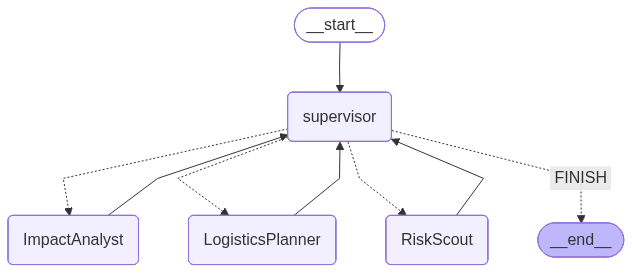

In [19]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [ ]:
import os
from typing import Annotated, List, TypedDict, Literal
from langchain_huggingface import HuggingFaceEndpoint
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage
from langchain_core.tools import tool
from langchain_ollama import ChatOllama
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import create_react_agent
from langgraph.checkpoint.memory import InMemorySaver
from langgraph.types import Command, interrupt
from langchain_core.runnables import RunnableConfig

llm = ChatOllama(model="llama3", temperature=0)

# --- 2. IE TOOLS (The 'Act' in ReAct) ---
@tool
def check_global_risk(location: str):
    """Checks for weather or labor-related disruptions in a specific industrial hub."""
    if "Taiwan" in location or "Hsinchu" in location:
        return "CRITICAL: Typhoon approaching Hsinchu Hub. Port closure expected for 72 hours."
    return "Status: Normal operations. No major threats detected."

@tool
def get_inventory_status(sku_id: str):
    """Queries ERP for stock levels, lead times, and safety stock thresholds."""
    db = {
        "SKU-001": {"part": "Semiconductors", "stock": 120, "safety": 500, "daily_use": 50},
        "SKU-002": {"part": "Lithium Cells", "stock": 2000, "safety": 1500, "daily_use": 100}
    }
    data = db.get(sku_id.upper(), "SKU not found in database.")
    return f"ERP DATA: {data}. Note: SKU-001 is below safety stock thresholds."

@tool
def logistics_cost_analyzer(mode: str):
    """Calculates the cost impact of switching logistics modes (Air vs Sea)."""
    costs = {"air": "$18,500 (2 days)", "sea": "$4,200 (15 days)"}
    return f"Quote for {mode} freight: {costs.get(mode.lower(), 'Invalid mode')}"

# --- 3. INITIALIZING ReAct AGENTS ---
# We use LangGraph's prebuilt ReAct agents for the worker nodes
risk_scout_agent = create_react_agent(llm, tools=[check_global_risk])
impact_analyst_agent = create_react_agent(llm, tools=[get_inventory_status])
planner_agent = create_react_agent(llm, tools=[logistics_cost_analyzer])

# --- 4. GRAPH STATE & SUPERVISOR ---
class AgentState(TypedDict):
    messages: Annotated[List[BaseMessage], add_messages]
    next_node: str

# --- 5. WRAPPER NODES (To bridge StateGraph and ReAct Agents) ---
def risk_scout_node(state: AgentState):
    print("--- [RISK SCOUT] Checking... ---")
    query = state["messages"][-1].content
    # STRICT PROMPT to prevent yapping about rock crushers
    prompt = f"You are a Supply Chain Risk Scout. Briefly (2 sentences) identify any weather or labor risks mentioned in: {query}. If it's a greeting, just say Hello."
    response = llm.invoke(prompt)
    return {"messages": [AIMessage(content=response.content)]}

def impact_analyst_node(state: AgentState):
    print("--- [IMPACT ANALYST] Analyzing... ---")
    # DO NOT use the word 'Crusher' or 'Mining' in the prompt
    prompt = "You are an Inventory Analyst. Check the state and briefly state the SKU stock level impact. Be concise."
    response = llm.invoke(prompt)
    return {"messages": [AIMessage(content=response.content)]}

# --- REFINED SUPERVISOR (To handle greetings) ---

def supervisor_node(state: AgentState):
    last_msg = state["messages"][-1].content.lower()
    
    # 1. Handle Greetings (Speed up 'hi' responses)
    if any(greet in last_msg for greet in ["hi", "hello", "hey"]):
        return {"next_node": "FINISH"}
        
    # 2. Sequential Logic
    history = " ".join([str(m.content) for m in state["messages"]])
    if "Risk" not in history:
        return {"next_node": "RiskScout"}
    elif "Inventory" not in history:
        return {"next_node": "ImpactAnalyst"}
    return {"next_node": "FINISH"}

# --- 6. BUILD & COMPILE ---
builder = StateGraph(AgentState)
builder.add_node("supervisor", supervisor_node)
builder.add_node("RiskScout", call_risk_scout)
builder.add_node("ImpactAnalyst", call_impact_analyst)
builder.add_node("LogisticsPlanner", call_logistics_planner)

builder.add_edge(START, "supervisor")
builder.add_conditional_edges("supervisor", lambda x: x["next_node"], {
    "RiskScout": "RiskScout",
    "ImpactAnalyst": "ImpactAnalyst",
    "LogisticsPlanner": "LogisticsPlanner",
    "FINISH": END
})
# Return to supervisor after each worker to check the checklist
builder.add_edge("RiskScout", "supervisor")
builder.add_edge("ImpactAnalyst", "supervisor")
builder.add_edge("LogisticsPlanner", "supervisor")

app = builder.compile(checkpointer=InMemorySaver())

# --- 7. INTERACTIVE EXECUTION ---
config = RunnableConfig(configurable={"thread_id": "IE_2026_PRO"}, recursion_limit=50)

print("\n" + "="*60)
print("IE MULTI-AGENT ReAct ORCHESTRATOR")
print("="*60)

while True:
    current_state = app.get_state(config)
    
    if current_state.next:
        print("\n" + "!"*20 + " HUMAN-IN-THE-LOOP PAUSE " + "!"*20)
        user_decision = input("Your Decision (yes/no): ")
        # Resuming with Command
        for event in app.stream(Command(resume=user_decision), config):
            for node, values in event.items():
                if "messages" in values:
                    print(f"\n[{node.upper()}]: {values['messages'][-1].content}")
    else:
        query = input("\nEnter Disruption Scenario (or 'exit'): ")
        if query.lower() in ['exit', 'quit']: break
        
        # Start new stream
        for event in app.stream({"messages": [HumanMessage(content=query)]}, config):
            for node, values in event.items():
                if "messages" in values:
                    print(f"\n[{node.upper()}]: {values['messages'][-1].content}")

AttributeError: 'HuggingFaceEndpoint' object has no attribute 'bind_tools'

In [2]:
import os
from typing import Annotated, List, TypedDict, Literal
from langchain_ollama import ChatOllama
from langgraph.graph.message import add_messages
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage
from langchain_core.tools import tool
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import create_react_agent
from langgraph.checkpoint.memory import InMemorySaver
from langgraph.types import Command, interrupt

# ============================================================================
# 1. INITIALIZE LOCAL MODEL
# ============================================================================
# Using Llama 3.2 3B for local speed and tool-handling precision
llm = ChatOllama(model="llama3.2", temperature=0)

# ============================================================================
# 2. IE TOOLS (The 'Act' in ReAct)
# ============================================================================
@tool
def check_global_risk(location: str):
    """Checks for weather or labor-related disruptions in a specific industrial hub."""
    if "Taiwan" in location or "Hsinchu" in location:
        return "CRITICAL: Typhoon approaching Hsinchu Hub. Port closure expected for 72 hours."
    return "Status: Normal operations. No major threats detected."

@tool
def get_inventory_status(sku_id: str):
    """Queries ERP for stock levels, lead times, and safety stock thresholds."""
    db = {
        "SKU-001": {"part": "Semiconductors", "stock": 120, "safety": 500, "daily_use": 50},
        "SKU-002": {"part": "Lithium Cells", "stock": 2000, "safety": 1500, "daily_use": 100}
    }
    # Ensure tool handles variations in SKU format
    data = db.get(sku_id.upper().replace(" ", ""), "SKU not found in database.")
    return f"ERP DATA: {data}. Note: SKU-001 is currently below safety stock thresholds."

@tool
def logistics_cost_analyzer(mode: str):
    """Calculates the cost impact of switching logistics modes (Air vs Sea)."""
    costs = {"air": "$18,500 (2 days)", "sea": "$4,200 (15 days)"}
    return f"Quote for {mode} freight: {costs.get(mode.lower(), 'Invalid mode')}"

# ============================================================================
# 3. INITIALIZING ReAct AGENT EXECUTORS
# ============================================================================
risk_scout_executor = create_react_agent(llm, tools=[check_global_risk])
impact_analyst_executor = create_react_agent(llm, tools=[get_inventory_status])
planner_executor = create_react_agent(llm, tools=[logistics_cost_analyzer])

# ============================================================================
# 4. STATE & NODES
# ============================================================================
class AgentState(TypedDict):
    messages: Annotated[List[BaseMessage], add_messages]
    next_node: str

def risk_scout_node(state: AgentState):
    print("\n🔍 [RISK SCOUT] Reasoning with Weather Tools...")
    response = risk_scout_executor.invoke(state)
    return {"messages": [AIMessage(content=f"RISK REPORT: {response['messages'][-1].content}")]}

def impact_analyst_node(state: AgentState):
    print("\n📊 [IMPACT ANALYST] Reasoning with ERP Tools...")
    response = impact_analyst_executor.invoke(state)
    return {"messages": [AIMessage(content=f"IMPACT ANALYSIS: {response['messages'][-1].content}")]}

def logistics_planner_node(state: AgentState):
    print("\n🚛 [LOGISTICS PLANNER] Developing Strategy...")
    # Trigger Human-in-the-Loop before final calculation
    proposal = "IE PROPOSAL: Switch SKU-001 to Air Freight to prevent line stoppage."
    decision = interrupt(f"\n{proposal}\nDo you authorize this expenditure? (yes/no): ")
    
    # After resume, let the ReAct agent finalize with the tool
    response = planner_executor.invoke({"messages": [HumanMessage(content=f"User approved: {decision}. Use logistics tool for Air cost.")]})
    return {"messages": [AIMessage(content=f"PLAN FINALIZED: {response['messages'][-1].content}")]}

# ============================================================================
# 5. SUPERVISOR & GRAPH
# ============================================================================
def supervisor_node(state: AgentState):
    history = " ".join([str(m.content) for m in state["messages"]])
    if "RISK REPORT" not in history:
        return {"next_node": "RiskScout"}
    elif "IMPACT ANALYSIS" not in history:
        return {"next_node": "ImpactAnalyst"}
    elif "PLAN FINALIZED" not in history:
        return {"next_node": "LogisticsPlanner"}
    return {"next_node": "FINISH"}

builder = StateGraph(AgentState)
builder.add_node("supervisor", supervisor_node)
builder.add_node("RiskScout", risk_scout_node)
builder.add_node("ImpactAnalyst", impact_analyst_node)
builder.add_node("LogisticsPlanner", logistics_planner_node)

builder.add_edge(START, "supervisor")
builder.add_conditional_edges("supervisor", lambda x: x["next_node"], {
    "RiskScout": "RiskScout", "ImpactAnalyst": "ImpactAnalyst", 
    "LogisticsPlanner": "LogisticsPlanner", "FINISH": END
})
builder.add_edge("RiskScout", "supervisor")
builder.add_edge("ImpactAnalyst", "supervisor")
builder.add_edge("LogisticsPlanner", "supervisor")

app = builder.compile(checkpointer=InMemorySaver())

# ============================================================================
# 6. EXECUTION LOOP
# ============================================================================
config = {"configurable": {"thread_id": "IE_FINAL_REACT_LOCAL"}, "recursion_limit": 30}

print("\n" + "="*60)
print("IE MULTI-AGENT ReAct COMMAND CENTER (OLLAMA + TOOLS)")
print("="*60)

while True:
    state = app.get_state(config)
    if state.next:
        decision = input("\n[MANAGER APPROVAL]: ")
        for event in app.stream(Command(resume=decision), config):
            for node, val in event.items():
                if "messages" in val: print(f"[{node.upper()}]: {val['messages'][-1].content}")
    else:
        query = input("\nYou: ")
        if query.lower() in ["quit", "exit"]: break
        for event in app.stream({"messages": [HumanMessage(content=query)]}, config):
            for node, val in event.items():
                if "messages" in val: print(f"[{node.upper()}]: {val['messages'][-1].content}")

AttributeError: '_SpecialForm' object has no attribute 'replace'

In [12]:
import os
from typing import Annotated, List, TypedDict, Literal
from langchain_huggingface import HuggingFaceEndpoint
from langchain_ollama import ChatOllama
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage
from langchain_core.tools import tool
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import create_react_agent
from langgraph.checkpoint.memory import InMemorySaver
from langgraph.types import Command, interrupt
from langchain_core.runnables import RunnableConfig
from dotenv import load_dotenv

In [13]:
model = ChatOllama(model="llama3.1", temperature=0)

In [14]:
# This supports native bind_tools() out of the box!

# --- 4. GRAPH LOGIC ---
class AgentState(TypedDict):
   messages: Annotated[List[BaseMessage], add_messages]
   next_node: str

In [15]:
# --- 2. IE TOOLS ---
@tool
def check_supply_risk(location: str):
    """Analyzes weather and labor risks for a specific hub."""
    if "Taiwan" in location or "Hsinchu" in location:
        return "CRITICAL: Typhoon approaching Hsinchu. Port closure expected."
    return "Status: Normal. No disruptions detected."

@tool
def check_inventory(sku: str):
    """Checks ERP database for stock levels."""
    return f"ERP DATA for {sku}: Stock=120, Safety=500. Result: Critical Stockout Risk."

In [18]:
# ReAct Agent Executors
risk_agent = create_react_agent(model=model, tools=[check_supply_risk])
impact_agent = create_react_agent(model=model, tools=[check_inventory])

AttributeError: '_SpecialForm' object has no attribute 'replace'